# SCC0275 - Introdução à Ciência de Dados - Primeiro Projeto Prático

**Nome do(s) Aluno(s):** João Pedro Borges de Castro

## Instalar pacotes

Este código precisa de algumas bibliotecas para rodar.<br>
Abaixo estão os comando para sua instalação:

In [ ]:
!pip install bitstring

## Código Auxiliar

In [ ]:
import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

from itertools import product
from bitstring import BitArray, Bits, BitStream

In [ ]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))

        self._mat2bytes(mat_rgb_ids)

    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()

        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=rgb_id, length=self.num_bits_uint_))

    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_

        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)

        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]

        return im_rgb

In [ ]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)

    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}

    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]

    return mat_ids, dict_id2pixel

In [ ]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

## Questão 1

### a) Ao estudar a função uniform_quant você irá perceber que ela gera os valores de R, G e B como o valor inicial do intervalo quantizado. Por exemplo, ao quantizar uma imagem uma parte do dicionário obtido é o exibido na figura abaixo. Modifique a função para que os valores de RGB sejam o meio do intervalo quantizado.

In [ ]:
def uniform_quant2(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size + (bin_size/2))   #soma (bin_size/2) elevando os valores de rgb para o meio do intervalo quantizado
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size + (bin_size/2))    #soma (bin_size/2)

    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}

    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]

    return mat_ids, dict_id2pixel

### b)Carregue a imagem 'china.jpg' usando o scikit-learn e mostre (no Jupyter Notebook) as 3 versões da imagem:

Original;

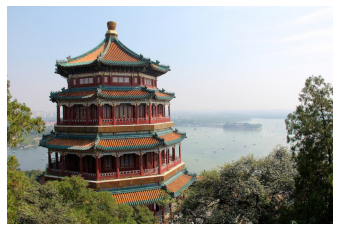

In [ ]:
im = load_sample_image("china.jpg")
plt.axis("off")
plt.imshow(im)

Quantizada para 64 cores usando o código original;

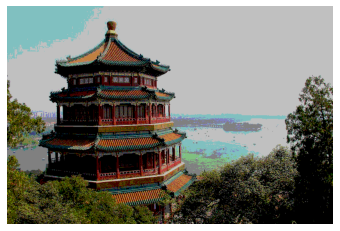

In [ ]:
matriz, dicio = uniform_quant(im, 64)
im2_comp = MyImgFormat(matriz, dicio)
im2 = im2_comp.unpack()
plt.axis("off")
plt.imshow(im2)

Quantizada para 64 cores usando o código feito no item anterior;

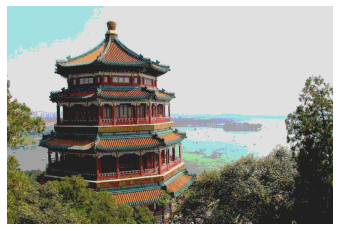

In [ ]:
matriz, dicio = uniform_quant2(im, 64)
im3_comp = MyImgFormat(matriz, dicio)
im3 = im3_comp.unpack()
plt.axis("off")
plt.imshow(im3)

### c) Comparar tamanho em KB das 3 imagens da questão anterior. (Dica: use a função get_bin_size_kb)

In [ ]:
tam_im = get_bin_size_kb(im)
print("Tamanho da imagem original: ", tam_im, "kb")
tam_im2_comp = get_bin_size_kb(im2_comp)
tam_im2 = get_bin_size_kb(im2)
print("Tamanho da imagem compactada usando o codigo original:", tam_im2_comp, "kb", "Tamanho da imagem descompactada usando o codigo original:", tam_im2, "kb")
tam_im3_comp = get_bin_size_kb(im3_comp)
tam_im3 = get_bin_size_kb(im3)
print("Tamanho da imagem compactada usando o codigo do item a) :", tam_im3_comp, "kb", "Tamanho da imagem descompactada usando o codigo do item a) :", tam_im3, "kb")

Tamanho da imagem original:  820.002 kb
Tamanho da imagem compactada usando o codigo original: 206.334 kb Tamanho da imagem descompactada usando o codigo original: 820.002 kb
Tamanho da imagem compactada usando o codigo do item a) : 206.334 kb Tamanho da imagem descompactada usando o codigo do item a) : 820.002 kb


Percebe-se, pela análise dos itens anteriores, que as imagens compactadas chegam a gastar apenas 1/3 do tamanho da imagem original, contudo, quando descompactadas, elas possuem o mesmo tamanho da imagem original e com perda de qualidade. Logo, conclui-se, que, os métodos de compactação utilizados anteriormente reduzem a qualidade das imagens, com o novo método deixando a imagem final um pouco mais clara, mas ainda com perda de nitidez. Assim, há uma perda de nitidez, mas também um uso bem menor de espaço de armazenamento.

## Questão 2

### a) Implementar uma estratégia de quantização de imagens usando o K-Means para determinar os valores RGB de cada um dos IDs das cores. Modifique os valores dos parâmetros do construtor da classe KMeans como achar necessário, mas deixe os parâmetros listados abaixo com os valores indicados para que seja fácil reproduzir seus resultados:
○ max_iter=10,
○ random_state=42

In [ ]:
class im_knn:
  def __init__(self, im, n_clusters):
    X_im = im.reshape(-1, 3)
    kmeans = KMeans(n_clusters, max_iter = 10, random_state=42)
    kmeans = kmeans.fit(X_im)
    clusters = kmeans.predict(X_im)

    self.im_clusters = np.uint8(clusters.reshape(427, 640))
    self.cluster_centers = kmeans.cluster_centers_.copy()

  def unpack(self):
    im_kmeans = np.zeros(im.shape)
    for i in range(self.im_clusters.shape[0]):
      for j in range(self.im_clusters.shape[1]):
        cluster_id = self.im_clusters[i, j]
        im_kmeans[i, j, :] = self.cluster_centers[cluster_id]
    im_kmeans = np.uint8(im_kmeans)
    return im_kmeans

### b) Rode o método usando o K-Means para quantizar a imagem 'china.jpg' para 64 cores e compare visualmente a imagem gerada com os resultados da Questão 1. Comente os resultados.

In [ ]:
knn_64 = im_knn(im, 64)

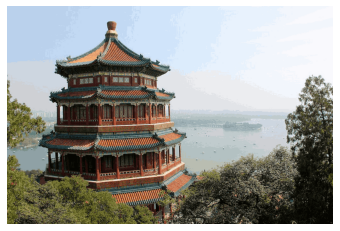

In [ ]:
im_kmeans = knn_64.unpack()
plt.axis("off")
plt.imshow(im_kmeans)

Utilizando o método K-Means, percebe-se que a imagem manteve um ótimo nível de nitidez, sendo perceptível apenas um pouco de perda na coloração do céu, em comparação com a imagem original. Mas, comparando com os métodos de compactação com perdas anteriores, o método K-Means provou que ele tem como produto uma imagem bem mais nitida, resultado de uma escolha mais inteligente das 64 cores que são utilizadas.

## Questão 3

### a) Existem diversas maneiras de se estimar a quantidade "ótima" de clusters para um algoritmos como K-Means. Uma delas é uma análise baseada na medida de inércia, que é apresentada neste link. Implemente o cálculo da inércia dentro da função de quantização baseada no K-Means.

In [ ]:
class im_knn_i:
  def __init__(self, im, n_clusters):
    X_im = im.reshape(-1, 3)
    kmeans = KMeans(n_clusters, max_iter = 10, random_state=42)
    kmeans = kmeans.fit(X_im)
    clusters = kmeans.predict(X_im)

    self.im_clusters = np.uint8(clusters.reshape(427, 640))
    self.cluster_centers = kmeans.cluster_centers_.copy()
    self.inercia = kmeans.inertia_   #calculo da inercia

  def unpack(self):
    im_kmeans = np.zeros(im.shape)
    for i in range(self.im_clusters.shape[0]):
      for j in range(self.im_clusters.shape[1]):
        cluster_id = self.im_clusters[i, j]
        im_kmeans[i, j, :] = self.cluster_centers[cluster_id]
    im_kmeans = np.uint8(im_kmeans)
    return im_kmeans

### b) Implemente uma função de comparação que calcula o MSE entre os pixels da imagem original e os da imagem quantizada.

In [ ]:
def MSE(imagem_original, imagem_quantizada):
  resultado = 0.00
  for i in range(imagem_original.shape[0]):
    for j in range(imagem_original.shape[1]):
      resultado += mean_squared_error(imagem_original[i][j], imagem_quantizada[i][j])
  return resultado

## Questão 4

### a) Faça a quantização das imagens para {8, 27, 64, 125, 216} cores usando ambos os métodos de quantização (uniforme e K-Means)

In [ ]:
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

In [ ]:
#Quantização de china.jpg para 8 cores
#uniforme
m, d = uniform_quant2(china, 8)
china_unif_8 = MyImgFormat(m, d)
#K-Means
china_kmeans_8 = im_knn_i(china, 8)

#Quantização de china.jpg para 27 cores
#uniforme
m, d = uniform_quant2(china, 27)
china_unif_27 = MyImgFormat(m, d)
#K-Means
china_kmeans_27 = im_knn_i(china, 27)

#Quantização de china.jpg para 64 cores
#uniforme
m, d = uniform_quant2(china, 64)
china_unif_64 = MyImgFormat(m, d)
#K-Means
china_kmeans_64 = im_knn_i(china, 64)

#Quantização de china.jpg para 125 cores
#uniforme
m, d = uniform_quant2(china, 125)
china_unif_125 = MyImgFormat(m, d)
#K-Means
china_kmeans_125 = im_knn_i(china, 125)

#Quantização de china.jpg para 216 cores
#uniforme
m, d = uniform_quant2(china, 216)
china_unif_216 = MyImgFormat(m, d)
#K-Means
china_kmeans_216 = im_knn_i(china, 216)

In [ ]:
#Quantização de flower.jpg para 8 cores
#uniforme
m, d = uniform_quant2(flower, 8)
flower_unif_8 = MyImgFormat(m, d)
#K-Means
flower_kmeans_8 = im_knn_i(flower, 8)
#Quantização de flower.jpg para 27 cores
#uniforme
m, d = uniform_quant2(flower, 27)
flower_unif_27 = MyImgFormat(m, d)
#K-Means
flower_kmeans_27 = im_knn_i(flower, 27)
#Quantização de flower.jpg para 64 cores
#uniforme
m, d = uniform_quant2(flower, 64)
flower_unif_64 = MyImgFormat(m, d)
#K-Means
flower_kmeans_64 = im_knn_i(flower, 64)
#Quantização de flower.jpg para 125 cores
#uniforme
m, d = uniform_quant2(flower, 125)
flower_unif_125 = MyImgFormat(m, d)
#K-Means
flower_kmeans_125 = im_knn_i(flower, 125)
#Quantização de flower.jpg para 216 cores
#uniforme
m, d = uniform_quant2(flower, 216)
flower_unif_216 = MyImgFormat(m, d)
#K-Means
flower_kmeans_216 = im_knn_i(flower, 216)

### b) Compute e faça um plot da inércia dos resultados das quantizações do K-Means obtidas no item a)

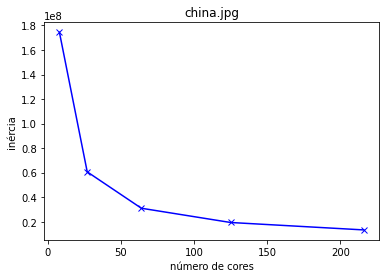

In [ ]:
china_in = [china_kmeans_8.inercia, china_kmeans_27.inercia, china_kmeans_64.inercia, china_kmeans_125.inercia, china_kmeans_216.inercia]
K = [8, 27, 64, 125, 216]
plt.plot(K, china_in, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('inércia')
plt.title('china.jpg')
plt.show()

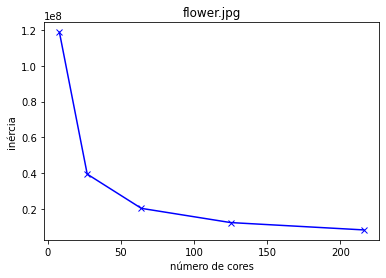

In [ ]:
flower_in = [flower_kmeans_8.inercia, flower_kmeans_27.inercia, flower_kmeans_64.inercia, flower_kmeans_125.inercia, flower_kmeans_216.inercia]
K = [8, 27, 64, 125, 216]
plt.plot(K, flower_in, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('inércia')
plt.title('flower.jpg')
plt.show()

### c) Compute e faça um plot dos MSEs de ambas as estratégias. Qual das estratégias teve um melhor MSE? Isso faz sentido quando fazemos uma comparação visual dos resultados?

In [ ]:
unp_china_unif_8 = china_unif_8.unpack()
unp_china_unif_27 = china_unif_27.unpack()
unp_china_unif_64 = china_unif_64.unpack()
unp_china_unif_125 = china_unif_125.unpack()
unp_china_unif_216 = china_unif_216.unpack()

unp_china_kmeans_8 = china_kmeans_8.unpack()
unp_china_kmeans_27 = china_kmeans_27.unpack()
unp_china_kmeans_64 = china_kmeans_64.unpack()
unp_china_kmeans_125 = china_kmeans_125.unpack()
unp_china_kmeans_216 = china_kmeans_216.unpack()

unp_flower_unif_8 = flower_unif_8.unpack()
unp_flower_unif_27 = flower_unif_27.unpack()
unp_flower_unif_64 = flower_unif_64.unpack()
unp_flower_unif_125 = flower_unif_125.unpack()
unp_flower_unif_216 = flower_unif_216.unpack()

unp_flower_kmeans_8 = flower_kmeans_8.unpack()
unp_flower_kmeans_27 = flower_kmeans_27.unpack()
unp_flower_kmeans_64 = flower_kmeans_64.unpack()
unp_flower_kmeans_125 = flower_kmeans_125.unpack()
unp_flower_kmeans_216 = flower_kmeans_216.unpack()

In [ ]:
china_MSE_unif = [MSE(china, unp_china_unif_8), MSE(china, unp_china_unif_27), MSE(china, unp_china_unif_64), MSE(china, unp_china_unif_125), MSE(china, unp_china_unif_216)]
china_MSE_kmeans = [MSE(china, unp_china_kmeans_8), MSE(china, unp_china_kmeans_27), MSE(china, unp_china_kmeans_64), MSE(china, unp_china_kmeans_125), MSE(china, unp_china_kmeans_216)]
flower_MSE_unif = [MSE(flower, unp_flower_unif_8), MSE(flower, unp_flower_unif_27), MSE(flower, unp_flower_unif_64), MSE(flower, unp_flower_unif_125), MSE(flower, unp_flower_unif_216)]
flower_MSE_kmeans = [MSE(flower, unp_flower_kmeans_8), MSE(flower, unp_flower_kmeans_27), MSE(flower, unp_flower_kmeans_64), MSE(flower, unp_flower_kmeans_125), MSE(flower, unp_flower_kmeans_216)]
K = [8, 27, 64, 125, 216]

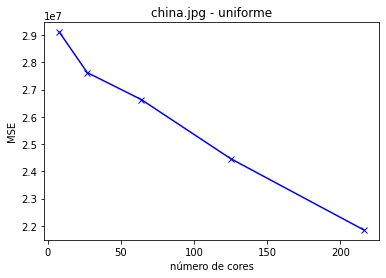

In [ ]:
plt.plot(K, china_MSE_unif, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('MSE')
plt.title('china.jpg - uniforme')
plt.show()

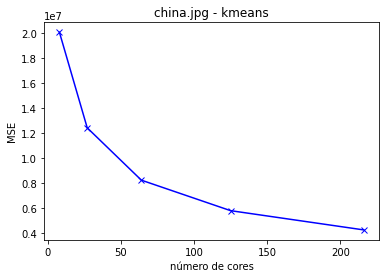

In [ ]:
plt.plot(K, china_MSE_kmeans, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('MSE')
plt.title('china.jpg - kmeans')
plt.show()

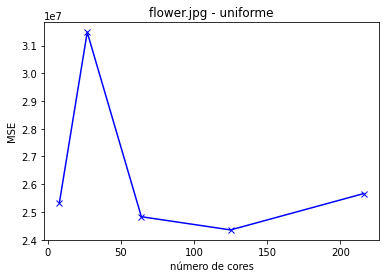

In [ ]:
plt.plot(K, flower_MSE_unif, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('MSE')
plt.title('flower.jpg - uniforme')
plt.show()

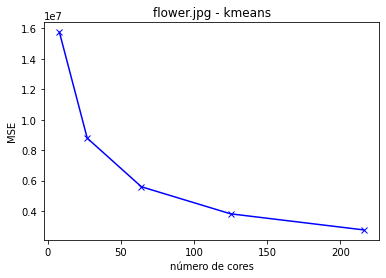

In [ ]:
plt.plot(K, flower_MSE_kmeans, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('MSE')
plt.title('flower.jpg - kmeans')
plt.show()

Analisando os gráficos acima, percebe-se, que, a estratégia do K-Means produz valores menores de erro em relação à imagem original, o que condiz com o fato de as imagens produzidas pelo K-Means serem mais parecidas com a imagem original do que as imagens da quantização uniforme, como visto nas questões 1 e 2.

### d) Compute e faça um plot do tamanho e KBs das imagens quantizadas e compare com o tamanho em KBs da imagem original.

In [ ]:
tam_china_unif = [get_bin_size_kb(china_unif_8), get_bin_size_kb(china_unif_27), get_bin_size_kb(china_unif_64), get_bin_size_kb(china_unif_125), get_bin_size_kb(china_unif_216)]
tam_china_kmeans = [get_bin_size_kb(china_kmeans_8), get_bin_size_kb(china_kmeans_27), get_bin_size_kb(china_kmeans_64), get_bin_size_kb(china_kmeans_125), get_bin_size_kb(china_kmeans_216)]
tam_flower_unif = [get_bin_size_kb(flower_unif_8), get_bin_size_kb(flower_unif_27), get_bin_size_kb(flower_unif_64), get_bin_size_kb(flower_unif_125), get_bin_size_kb(flower_unif_216)]
tam_flower_kmeans = [get_bin_size_kb(flower_kmeans_8), get_bin_size_kb(flower_kmeans_27), get_bin_size_kb(flower_kmeans_64), get_bin_size_kb(flower_kmeans_125), get_bin_size_kb(flower_kmeans_216)]
K = [8, 27, 64, 125, 216]

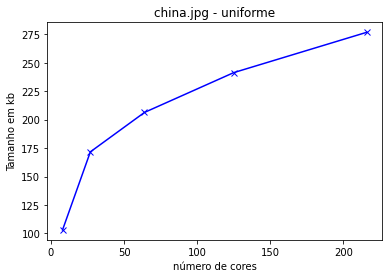

In [ ]:
plt.plot(K, tam_china_unif, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('Tamanho em kb')
plt.title('china.jpg - uniforme')
plt.show()

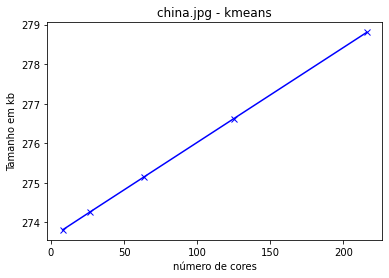

In [ ]:
plt.plot(K, tam_china_kmeans, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('Tamanho em kb')
plt.title('china.jpg - kmeans')
plt.show()

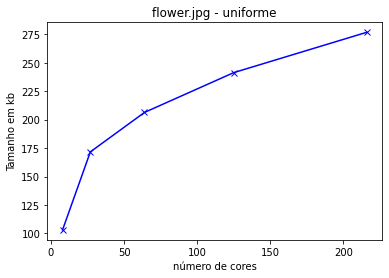

In [ ]:
plt.plot(K, tam_flower_unif, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('Tamanho em kb')
plt.title('flower.jpg - uniforme')
plt.show()

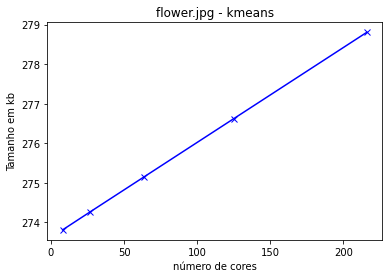

In [ ]:
plt.plot(K, tam_flower_kmeans, 'bx-')
plt.xlabel('número de cores')
plt.ylabel('Tamanho em kb')
plt.title('flower.jpg - kmeans')
plt.show()

In [ ]:
print("Tamanho de china.jpg sem compressão:", get_bin_size_kb(china))
print("Tamanho de flower.jpg sem compressão:", get_bin_size_kb(flower))

Tamanho de china.jpg sem compressão: 820.002
Tamanho de flower.jpg sem compressão: 820.002


Percebe-se que as compressões são bem sucedidas, pois, estas ocupam menos de 300 kb, enquanto as fotos originais ocupam 820 kb.